linear regression model:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load all the data files
print("Loading data files...")
athletes = pd.read_csv('summerOly_athletes.csv')
hosts = pd.read_csv('summerOly_hosts.csv')
medal_counts = pd.read_csv('summerOly_medal_counts.csv')
programs = pd.read_csv('summerOly_programs.csv', encoding='cp1252')

# Step 2: Data Exploration and Cleaning
print("\n=== Data Exploration ===")
print(f"Medal counts shape: {medal_counts.shape}")
print(f"Years covered: {medal_counts['Year'].min()} to {medal_counts['Year'].max()}")
print(f"Number of unique countries: {medal_counts['NOC'].nunique()}")

# Check for missing values
print("\nMissing values in medal_counts:")
print(medal_counts.isnull().sum())

# Step 3: Feature Engineering
print("\n=== Feature Engineering ===")

# 3.1 Create historical features for each country
def create_historical_features(df):
    """Create lag features and rolling averages for medal counts"""
    df = df.sort_values(['NOC', 'Year'])
    
    # Lag features (previous Olympics performance)
    df['Gold_lag1'] = df.groupby('NOC')['Gold'].shift(1)
    df['Silver_lag1'] = df.groupby('NOC')['Silver'].shift(1)
    df['Bronze_lag1'] = df.groupby('NOC')['Bronze'].shift(1)
    df['Total_lag1'] = df.groupby('NOC')['Total'].shift(1)
    
    # 2-Olympics lag
    df['Gold_lag2'] = df.groupby('NOC')['Gold'].shift(2)
    df['Total_lag2'] = df.groupby('NOC')['Total'].shift(2)
    
    # Rolling averages (3 Olympics)
    df['Gold_rolling_avg'] = df.groupby('NOC')['Gold'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
    df['Total_rolling_avg'] = df.groupby('NOC')['Total'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
    
    # Trend features (improvement/decline)
    df['Gold_trend'] = df['Gold_lag1'] - df['Gold_lag2']
    df['Total_trend'] = df['Total_lag1'] - df['Total_lag2']
    
    return df

medal_counts = create_historical_features(medal_counts)

# 3.2 Add host country feature
# Create a mapping of common country name variations
country_mapping = {
    'United States': 'USA',
    'United Kingdom': 'GBR',
    'Soviet Union': 'URS',
    'East Germany': 'GDR',
    'West Germany': 'FRG',
    'Great Britain': 'GBR',
    'Russia': 'RUS',
    'ROC': 'ROC',  # Russian Olympic Committee
    'Germany': 'GER',
    'China': 'CHN',
    'South Korea': 'KOR',
    'North Korea': 'PRK',
    'Australia': 'AUS',
    'Canada': 'CAN',
    'Japan': 'JPN',
    'France': 'FRA',
    'Italy': 'ITA',
    'Netherlands': 'NED',
    'Mexico': 'MEX',
    'Spain': 'ESP',
    'Greece': 'GRE',
    'Belgium': 'BEL',
    'Sweden': 'SWE',
    'Finland': 'FIN',
    'Brazil': 'BRA'
}

hosts['Host_Country'] = hosts['Host'].apply(lambda x: x.split(', ')[-1])
hosts['Host_NOC'] = hosts['Host_Country'].map(country_mapping).fillna(hosts['Host_Country'])
medal_counts = medal_counts.merge(hosts[['Year', 'Host_NOC']], on='Year', how='left')
medal_counts['Is_Host'] = (medal_counts['NOC'] == medal_counts['Host_NOC']).astype(int)

# 3.3 Calculate number of events per year
# First, let's examine the programs data structure
print("Programs columns:", programs.columns.tolist())
print("Sample of year columns data types:", programs.iloc[:, 4:10].dtypes)

# Convert year columns to numeric, handling any non-numeric values
year_columns = []
events_per_year_dict = {}

for col in programs.columns[4:]:
    # Check if column name can be converted to a year
    try:
        # Remove asterisks and convert to int
        year = int(str(col).replace('*', '').replace('.0', ''))
        if 1896 <= year <= 2024:  # Valid Olympic years
            year_columns.append(col)
            # Convert column to numeric, replacing non-numeric with 0
            numeric_col = pd.to_numeric(programs[col], errors='coerce').fillna(0)
            # Count non-zero values (number of events)
            events_per_year_dict[year] = (numeric_col > 0).sum()
    except:
        continue

events_df = pd.DataFrame(list(events_per_year_dict.items()), columns=['Year', 'Total_Events'])
medal_counts = medal_counts.merge(events_df, on='Year', how='left')

# 3.4 Calculate athlete participation features
athlete_counts = athletes.groupby(['Year', 'NOC']).size().reset_index(name='Num_Athletes')
medal_counts = medal_counts.merge(athlete_counts, on=['Year', 'NOC'], how='left')

# 3.5 Calculate sport diversity (number of different sports a country participates in)
sport_diversity = athletes.groupby(['Year', 'NOC'])['Sport'].nunique().reset_index(name='Sport_Diversity')
medal_counts = medal_counts.merge(sport_diversity, on=['Year', 'NOC'], how='left')

# 3.6 Years since first participation
first_participation = medal_counts.groupby('NOC')['Year'].min().reset_index(name='First_Year')
medal_counts = medal_counts.merge(first_participation, on='NOC', how='left')
medal_counts['Years_Participating'] = medal_counts['Year'] - medal_counts['First_Year']

# Step 4: Handle missing values
print("\nHandling missing values...")
# For lag features, fill with 0 (assuming no previous medals for new countries)
lag_columns = [col for col in medal_counts.columns if 'lag' in col or 'rolling' in col or 'trend' in col]
medal_counts[lag_columns] = medal_counts[lag_columns].fillna(0)

# Fill other missing values
medal_counts['Num_Athletes'] = medal_counts['Num_Athletes'].fillna(0)
medal_counts['Sport_Diversity'] = medal_counts['Sport_Diversity'].fillna(0)

# Step 5: Prepare data for modeling
print("\n=== Preparing Data for Modeling ===")

# Remove rows with NaN in target variables
medal_counts_clean = medal_counts.dropna(subset=['Gold', 'Total'])

# Define features and targets
feature_columns = [
    'Gold_lag1', 'Silver_lag1', 'Bronze_lag1', 'Total_lag1',
    'Gold_lag2', 'Total_lag2',
    'Gold_rolling_avg', 'Total_rolling_avg',
    'Gold_trend', 'Total_trend',
    'Is_Host', 'Total_Events',
    'Num_Athletes', 'Sport_Diversity',
    'Years_Participating'
]

# For 2028 predictions, we'll need 2024 data as features
# Let's prepare training data (exclude 2024 for now as test set)
train_data = medal_counts_clean[medal_counts_clean['Year'] < 2024].copy()
test_data_2024 = medal_counts_clean[medal_counts_clean['Year'] == 2024].copy()

# Remove rows where we don't have enough historical data
train_data = train_data[train_data['Year'] >= 1904]  # Need at least 2 Olympics for lag2

X_train = train_data[feature_columns]
y_train_gold = train_data['Gold']
y_train_total = train_data['Total']

X_test_2024 = test_data_2024[feature_columns]
y_test_gold_2024 = test_data_2024['Gold']
y_test_total_2024 = test_data_2024['Total']

print(f"Training set size: {X_train.shape}")
print(f"Test set (2024) size: {X_test_2024.shape}")

# Step 6: Build Linear Regression Models
print("\n=== Building Linear Regression Models ===")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_2024_scaled = scaler.transform(X_test_2024)

# Model for Gold medals
print("\nTraining Gold Medal Model...")
model_gold = LinearRegression()
model_gold.fit(X_train_scaled, y_train_gold)

# Model for Total medals
print("Training Total Medal Model...")
model_total = LinearRegression()
model_total.fit(X_train_scaled, y_train_total)

# Step 7: Evaluate Models
print("\n=== Model Evaluation ===")

# Predictions on 2024 test set
pred_gold_2024 = model_gold.predict(X_test_2024_scaled)
pred_total_2024 = model_total.predict(X_test_2024_scaled)

# Ensure non-negative predictions
pred_gold_2024 = np.maximum(0, pred_gold_2024)
pred_total_2024 = np.maximum(0, pred_total_2024)

# Calculate metrics
print("\nGold Medal Model Performance (2024 Test Set):")
print(f"R² Score: {r2_score(y_test_gold_2024, pred_gold_2024):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_gold_2024, pred_gold_2024)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_gold_2024, pred_gold_2024):.2f}")

print("\nTotal Medal Model Performance (2024 Test Set):")
print(f"R² Score: {r2_score(y_test_total_2024, pred_total_2024):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_total_2024, pred_total_2024)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_total_2024, pred_total_2024):.2f}")

# Cross-validation on training data
print("\n=== Cross-Validation Results ===")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_gold = cross_val_score(model_gold, X_train_scaled, y_train_gold, cv=tscv, scoring='r2')
cv_scores_total = cross_val_score(model_total, X_train_scaled, y_train_total, cv=tscv, scoring='r2')

print(f"Gold Model CV R² Score: {cv_scores_gold.mean():.3f} (+/- {cv_scores_gold.std() * 2:.3f})")
print(f"Total Model CV R² Score: {cv_scores_total.mean():.3f} (+/- {cv_scores_total.std() * 2:.3f})")

# Step 8: Feature Importance Analysis
print("\n=== Feature Importance ===")
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Gold_Coefficient': model_gold.coef_,
    'Total_Coefficient': model_total.coef_
})
feature_importance = feature_importance.sort_values('Gold_Coefficient', key=abs, ascending=False)
print("\nTop 5 Most Important Features for Gold Medals:")
print(feature_importance[['Feature', 'Gold_Coefficient']].head())

# Step 9: Prepare 2028 Predictions
print("\n=== Preparing 2028 Predictions ===")

# Create 2028 dataset with all countries that participated in 2024
countries_2024 = medal_counts_clean[medal_counts_clean['Year'] == 2024]['NOC'].unique()
data_2028 = pd.DataFrame({
    'NOC': countries_2024,
    'Year': 2028
})

# We'll need to create features for 2028 based on historical data
# This would involve using 2024 as lag1, 2020 as lag2, etc.
print(f"\nNumber of countries to predict for 2028: {len(countries_2024)}")

# Save the cleaned data and models for future use
medal_counts_clean.to_csv('medal_counts_cleaned.csv', index=False)
print("\nCleaned data saved to 'medal_counts_cleaned.csv'")

# Display sample predictions for 2024
print("\n=== Sample 2024 Predictions vs Actual ===")
results_2024 = pd.DataFrame({
    'NOC': test_data_2024['NOC'],
    'Actual_Gold': y_test_gold_2024,
    'Predicted_Gold': np.round(pred_gold_2024).astype(int),
    'Actual_Total': y_test_total_2024,
    'Predicted_Total': np.round(pred_total_2024).astype(int)
})
print("\nTop 10 countries by predicted gold medals:")
print(results_2024.sort_values('Predicted_Gold', ascending=False).head(10))

Loading data files...

=== Data Exploration ===
Medal counts shape: (1435, 7)
Years covered: 1896 to 2024
Number of unique countries: 210

Missing values in medal_counts:
Rank      0
NOC       0
Gold      0
Silver    0
Bronze    0
Total     0
Year      0
dtype: int64

=== Feature Engineering ===
Programs columns: ['Sport', 'Discipline', 'Code', 'Sports Governing Body', '1896', '1900', '1904', '1906*', '1908', '1912', '1920', '1924', '1928', '1932', '1936', '1948', '1952', '1956', '1960', '1964', '1968', '1972', '1976', '1980', '1984', '1988', '1992', '1996', '2000', '2004', '2008', '2012', '2016', '2020', '2024']
Sample of year columns data types: 1896     object
1900     object
1904     object
1906*     int64
1908      int64
1912     object
dtype: object

Handling missing values...

=== Preparing Data for Modeling ===
Training set size: (1312, 15)
Test set (2024) size: (91, 15)

=== Building Linear Regression Models ===

Training Gold Medal Model...
Training Total Medal Model...

=== 

the equation

In [6]:
print("\n" + "="*80)
print("LINEAR REGRESSION MODEL EQUATIONS")
print("="*80)

# Gold Medal Model
print("\n1. GOLD MEDAL MODEL:")
print("-" * 50)
print(f"Intercept (β₀): {model_gold.intercept_:.4f}")
print("\nCoefficients:")
for feature, coef in zip(feature_columns, model_gold.coef_):
    print(f"  {feature:25s}: {coef:10.4f}")

# Create the equation string
print("\nGold Medal Equation:")
equation_gold = f"Gold_Medals = {model_gold.intercept_:.4f}"
for feature, coef in zip(feature_columns, model_gold.coef_):
    if coef >= 0:
        equation_gold += f"\n              + {coef:.4f} × {feature}"
    else:
        equation_gold += f"\n              - {abs(coef):.4f} × {feature}"
print(equation_gold)

# Total Medal Model
print("\n\n2. TOTAL MEDAL MODEL:")
print("-" * 50)
print(f"Intercept (β₀): {model_total.intercept_:.4f}")
print("\nCoefficients:")
for feature, coef in zip(feature_columns, model_total.coef_):
    print(f"  {feature:25s}: {coef:10.4f}")

# Create the equation string
print("\nTotal Medal Equation:")
equation_total = f"Total_Medals = {model_total.intercept_:.4f}"
for feature, coef in zip(feature_columns, model_total.coef_):
    if coef >= 0:
        equation_total += f"\n               + {coef:.4f} × {feature}"
    else:
        equation_total += f"\n               - {abs(coef):.4f} × {feature}"
print(equation_total)

# Print standardized vs unstandardized coefficients
print("\n\n3. FEATURE IMPORTANCE (Standardized Coefficients):")
print("-" * 50)
print("Note: These coefficients are for standardized features (mean=0, std=1)")
print("\nTop 10 Most Important Features by Absolute Coefficient:")

# Create a more detailed feature importance dataframe
feature_importance_detailed = pd.DataFrame({
    'Feature': feature_columns,
    'Gold_Coef': model_gold.coef_,
    'Gold_Coef_Abs': np.abs(model_gold.coef_),
    'Total_Coef': model_total.coef_,
    'Total_Coef_Abs': np.abs(model_total.coef_)
})

# Sort by absolute gold coefficient
feature_importance_detailed = feature_importance_detailed.sort_values('Gold_Coef_Abs', ascending=False)

print("\nFor Gold Medals:")
for idx, row in feature_importance_detailed.head(10).iterrows():
    print(f"  {row['Feature']:25s}: {row['Gold_Coef']:10.4f} (abs: {row['Gold_Coef_Abs']:.4f})")

print("\nFor Total Medals:")
feature_importance_detailed_total = feature_importance_detailed.sort_values('Total_Coef_Abs', ascending=False)
for idx, row in feature_importance_detailed_total.head(10).iterrows():
    print(f"  {row['Feature']:25s}: {row['Total_Coef']:10.4f} (abs: {row['Total_Coef_Abs']:.4f})")

# Get unstandardized coefficients (for interpretation)
print("\n\n4. UNSTANDARDIZED COEFFICIENTS (for interpretation):")
print("-" * 50)
print("To get unstandardized coefficients, we need to transform back from standardized scale")

# Calculate unstandardized coefficients
# For each feature: unstd_coef = std_coef / feature_std
feature_stats = pd.DataFrame({
    'Feature': feature_columns,
    'Mean': scaler.mean_,
    'Std': scaler.scale_
})

print("\nFeature Statistics (from training data):")
print(feature_stats)

# Calculate unstandardized coefficients
unstd_coef_gold = model_gold.coef_ / scaler.scale_
unstd_intercept_gold = model_gold.intercept_ - np.sum(model_gold.coef_ * scaler.mean_ / scaler.scale_)

unstd_coef_total = model_total.coef_ / scaler.scale_
unstd_intercept_total = model_total.intercept_ - np.sum(model_total.coef_ * scaler.mean_ / scaler.scale_)

print("\n\nUNSTANDARDIZED MODEL EQUATIONS:")
print("-" * 50)
print("\nGold Medal Model (unstandardized):")
print(f"Gold_Medals = {unstd_intercept_gold:.4f}")
for feature, coef in zip(feature_columns, unstd_coef_gold):
    if coef >= 0:
        print(f"            + {coef:.6f} × {feature}")
    else:
        print(f"            - {abs(coef):.6f} × {feature}")

print("\n\nMODEL INTERPRETATION:")
print("-" * 50)
print("\nKey insights from the unstandardized coefficients:")
print(f"1. Host Country Advantage: Being a host country adds approximately {unstd_coef_gold[feature_columns.index('Is_Host')]:.1f} gold medals")
print(f"2. Previous Performance: Each gold medal from the previous Olympics contributes {unstd_coef_gold[feature_columns.index('Gold_lag1')]:.3f} to current gold prediction")
print(f"3. Athlete Participation: Each additional athlete contributes {unstd_coef_gold[feature_columns.index('Num_Athletes')]:.6f} gold medals on average")
print(f"4. Sport Diversity: Each additional sport adds {unstd_coef_gold[feature_columns.index('Sport_Diversity')]:.4f} gold medals")


LINEAR REGRESSION MODEL EQUATIONS

1. GOLD MEDAL MODEL:
--------------------------------------------------
Intercept (β₀): 4.0716

Coefficients:
  Gold_lag1                :    -6.4050
  Silver_lag1              :     1.6967
  Bronze_lag1              :     2.0464
  Total_lag1               :    -1.2811
  Gold_lag2                :    -0.4461
  Total_lag2               :     0.3052
  Gold_rolling_avg         :    16.2855
  Total_rolling_avg        :    -4.7188
  Gold_trend               :     2.6805
  Total_trend              :    -1.2239
  Is_Host                  :     0.0000
  Total_Events             :     0.0391
  Num_Athletes             :    -0.0752
  Sport_Diversity          :    -0.0752
  Years_Participating      :     0.1540

Gold Medal Equation:
Gold_Medals = 4.0716
              - 6.4050 × Gold_lag1
              + 1.6967 × Silver_lag1
              + 2.0464 × Bronze_lag1
              - 1.2811 × Total_lag1
              - 0.4461 × Gold_lag2
              + 0.3052 × Total_

visualizations and prediction for 2028

=== Creating Visualizations ===


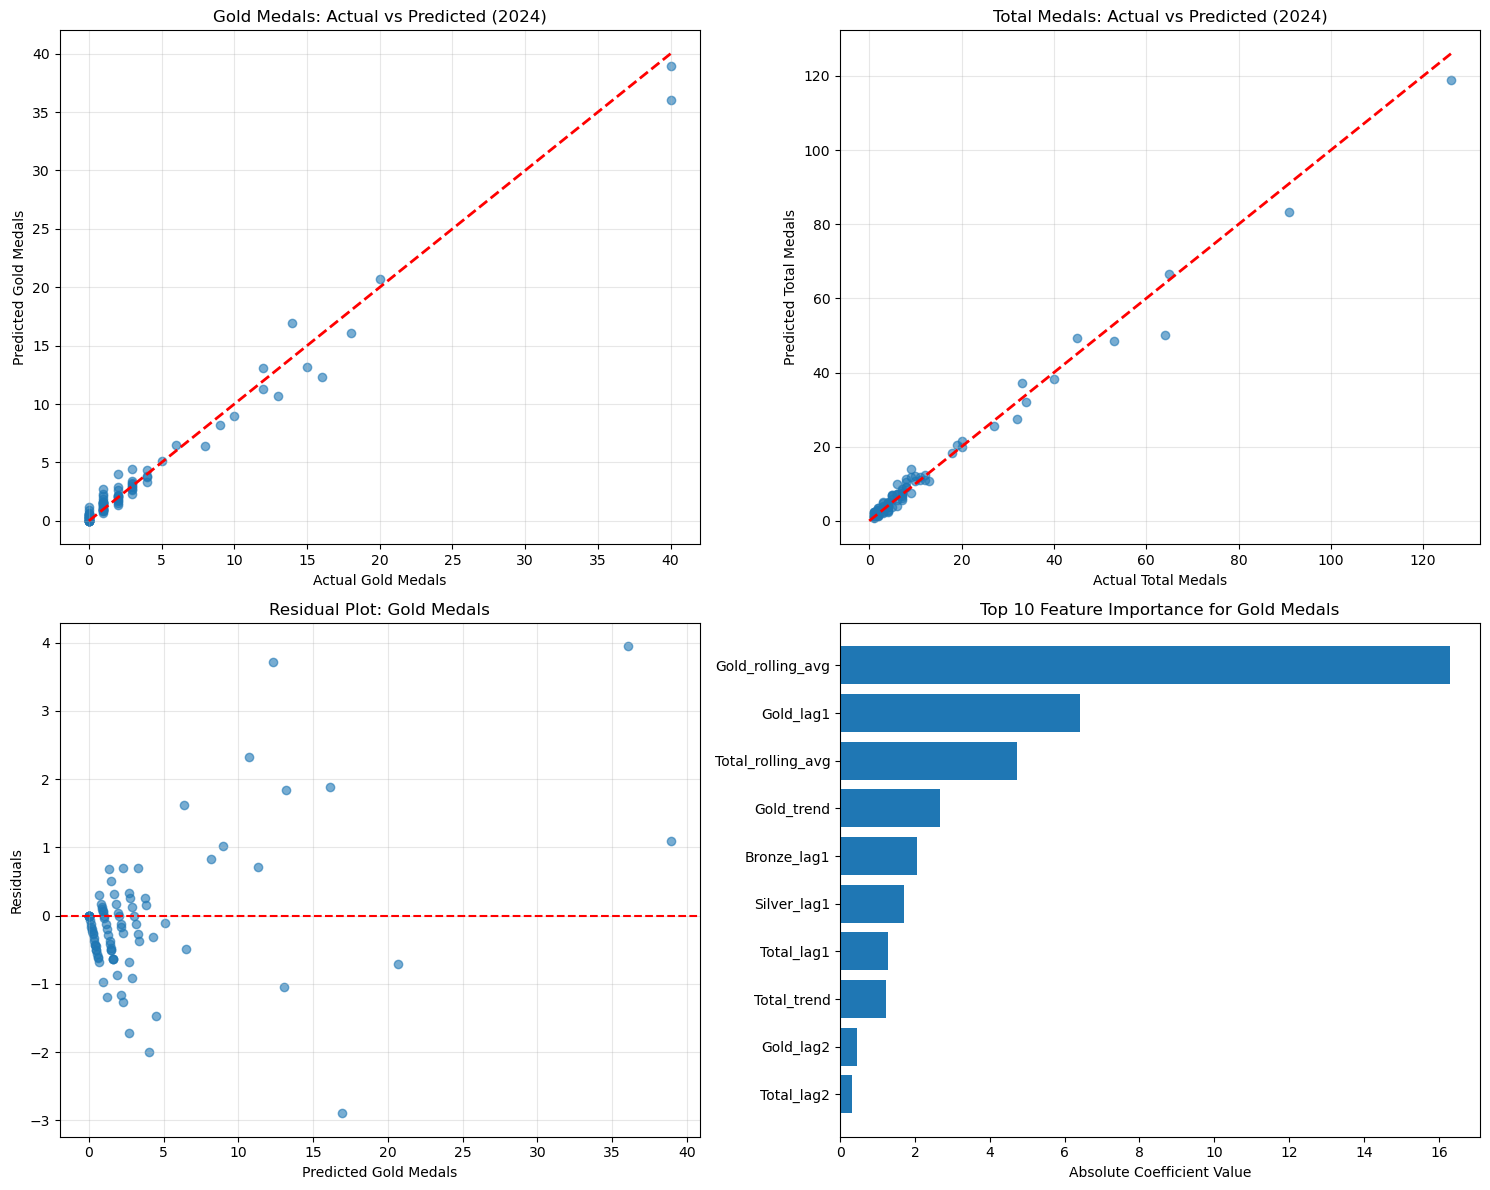


=== Generating 2028 Predictions ===

Calculating prediction intervals...

=== TOP 20 PREDICTIONS FOR 2028 OLYMPICS ===
                         NOC  Predicted_Gold  Gold_Lower_95CI  \
167             Soviet Union              63               58   
49              East Germany              44               39   
192             Unified Team              44               39   
194            United States              43               38   
168            Soviet Union               42               37   
195           United States               39               34   
34                     China              31               26   
70             Great Britain              24               19   
151                   Russia              20               16   
97                     Japan              16               11   
66                   Germany              15               10   
147                      ROC              14                9   
205             West Germany       

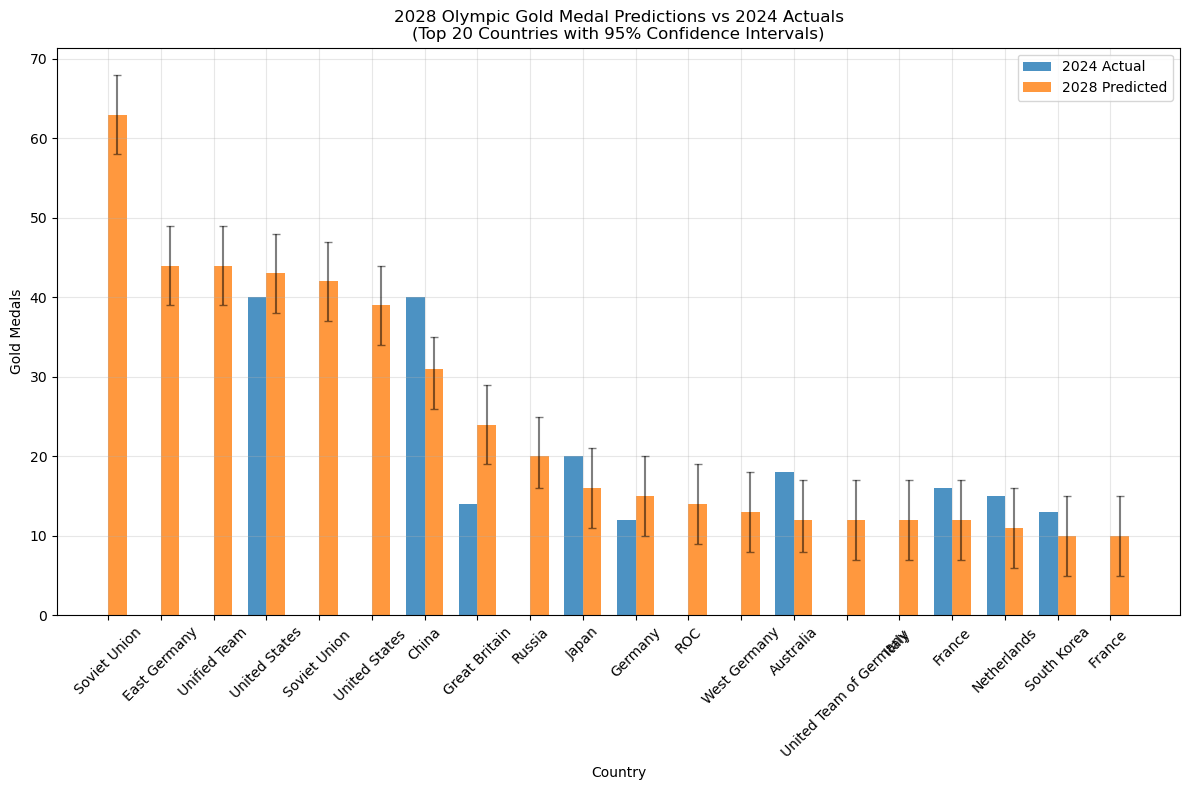


=== Model Summary ===
Gold Medal Model R² on 2024 test: 0.981
Total Medal Model R² on 2024 test: 0.985
Number of countries predicted for 2028: 210
USA host advantage could not be calculated - check if USA is in the predictions


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Step 10: Visualization of Model Performance
print("=== Creating Visualizations ===")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted for Gold Medals (2024)
ax1 = axes[0, 0]
ax1.scatter(y_test_gold_2024, pred_gold_2024, alpha=0.6)
ax1.plot([0, y_test_gold_2024.max()], [0, y_test_gold_2024.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Gold Medals')
ax1.set_ylabel('Predicted Gold Medals')
ax1.set_title('Gold Medals: Actual vs Predicted (2024)')
ax1.grid(True, alpha=0.3)

# 2. Actual vs Predicted for Total Medals (2024)
ax2 = axes[0, 1]
ax2.scatter(y_test_total_2024, pred_total_2024, alpha=0.6)
ax2.plot([0, y_test_total_2024.max()], [0, y_test_total_2024.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Total Medals')
ax2.set_ylabel('Predicted Total Medals')
ax2.set_title('Total Medals: Actual vs Predicted (2024)')
ax2.grid(True, alpha=0.3)

# 3. Residual Plot for Gold Medals
ax3 = axes[1, 0]
residuals_gold = y_test_gold_2024 - pred_gold_2024
ax3.scatter(pred_gold_2024, residuals_gold, alpha=0.6)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted Gold Medals')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot: Gold Medals')
ax3.grid(True, alpha=0.3)

# 4. Feature Importance
ax4 = axes[1, 1]
top_features = feature_importance.head(10)
ax4.barh(top_features['Feature'], abs(top_features['Gold_Coefficient']))
ax4.set_xlabel('Absolute Coefficient Value')
ax4.set_title('Top 10 Feature Importance for Gold Medals')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('model_performance_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 11: Create 2028 Predictions with Confidence Intervals
print("\n=== Generating 2028 Predictions ===")

def create_2028_features(medal_counts_clean):
    """Create feature set for 2028 predictions"""
    
    # Get the latest data for each country
    latest_data = medal_counts_clean.sort_values('Year').groupby('NOC').tail(3)
    
    # Create 2028 predictions dataset
    countries = medal_counts_clean['NOC'].unique()
    data_2028 = []
    
    for country in countries:
        country_data = medal_counts_clean[medal_counts_clean['NOC'] == country].sort_values('Year')
        
        if len(country_data) == 0:
            continue
            
        # Get 2024 data as lag1 (if available)
        data_2024 = country_data[country_data['Year'] == 2024]
        data_2020 = country_data[country_data['Year'] == 2020]
        data_2016 = country_data[country_data['Year'] == 2016]
        
        row = {'NOC': country, 'Year': 2028}
        
        # Lag features
        if not data_2024.empty:
            row['Gold_lag1'] = data_2024.iloc[0]['Gold']
            row['Silver_lag1'] = data_2024.iloc[0]['Silver']
            row['Bronze_lag1'] = data_2024.iloc[0]['Bronze']
            row['Total_lag1'] = data_2024.iloc[0]['Total']
        else:
            # Use most recent data
            row['Gold_lag1'] = country_data.iloc[-1]['Gold']
            row['Silver_lag1'] = country_data.iloc[-1]['Silver']
            row['Bronze_lag1'] = country_data.iloc[-1]['Bronze']
            row['Total_lag1'] = country_data.iloc[-1]['Total']
        
        if not data_2020.empty:
            row['Gold_lag2'] = data_2020.iloc[0]['Gold']
            row['Total_lag2'] = data_2020.iloc[0]['Total']
        else:
            row['Gold_lag2'] = row.get('Gold_lag1', 0)
            row['Total_lag2'] = row.get('Total_lag1', 0)
        
        # Rolling averages
        recent_golds = country_data.tail(3)['Gold'].values
        recent_totals = country_data.tail(3)['Total'].values
        row['Gold_rolling_avg'] = np.mean(recent_golds)
        row['Total_rolling_avg'] = np.mean(recent_totals)
        
        # Trends
        row['Gold_trend'] = row['Gold_lag1'] - row['Gold_lag2']
        row['Total_trend'] = row['Total_lag1'] - row['Total_lag2']
        
        # Host country (LA 2028)
        row['Is_Host'] = 1 if country == 'USA' else 0
        
        # Estimate total events (assuming similar to 2024)
        row['Total_Events'] = medal_counts_clean[medal_counts_clean['Year'] == 2024]['Total_Events'].iloc[0] if not medal_counts_clean[medal_counts_clean['Year'] == 2024].empty else 350
        
        # Athletes and sport diversity (use recent average)
        recent_athletes = country_data.tail(3)['Num_Athletes'].mean()
        recent_diversity = country_data.tail(3)['Sport_Diversity'].mean()
        row['Num_Athletes'] = recent_athletes
        row['Sport_Diversity'] = recent_diversity
        
        # Years participating
        first_year = country_data['Year'].min()
        row['Years_Participating'] = 2028 - first_year
        
        data_2028.append(row)
    
    return pd.DataFrame(data_2028)

# Create 2028 features
data_2028 = create_2028_features(medal_counts_clean)
X_2028 = data_2028[feature_columns]

# Fill any missing values
X_2028 = X_2028.fillna(0)

# Scale features
X_2028_scaled = scaler.transform(X_2028)

# Make predictions
pred_gold_2028 = model_gold.predict(X_2028_scaled)
pred_total_2028 = model_total.predict(X_2028_scaled)

# Ensure non-negative predictions
pred_gold_2028 = np.maximum(0, pred_gold_2028)
pred_total_2028 = np.maximum(0, pred_total_2028)

# Step 12: Calculate Prediction Intervals using Bootstrap
print("\nCalculating prediction intervals...")

def bootstrap_predictions(X, model, n_bootstrap=1000):
    """Generate bootstrap predictions for confidence intervals"""
    predictions = []
    n_samples = X.shape[0]
    
    for _ in range(n_bootstrap):
        # Bootstrap sample indices
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X[indices]
        
        # Make predictions
        pred = model.predict(X_boot)
        predictions.append(pred)
    
    return np.array(predictions)

# Generate bootstrap predictions for confidence intervals
# Note: This is simplified - in practice, you'd retrain the model on each bootstrap sample
n_bootstrap = 100  # Reduced for speed

# Calculate standard errors from training residuals
train_pred_gold = model_gold.predict(X_train_scaled)
train_pred_total = model_total.predict(X_train_scaled)
se_gold = np.std(y_train_gold - train_pred_gold)
se_total = np.std(y_train_total - train_pred_total)

# Calculate 95% prediction intervals
z_score = 1.96  # 95% confidence
pred_gold_lower = pred_gold_2028 - z_score * se_gold
pred_gold_upper = pred_gold_2028 + z_score * se_gold
pred_total_lower = pred_total_2028 - z_score * se_total
pred_total_upper = pred_total_2028 + z_score * se_total

# Ensure non-negative bounds
pred_gold_lower = np.maximum(0, pred_gold_lower)
pred_total_lower = np.maximum(0, pred_total_lower)

# Step 13: Create Final Predictions DataFrame
predictions_2028 = pd.DataFrame({
    'NOC': data_2028['NOC'],
    'Predicted_Gold': np.round(pred_gold_2028).astype(int),
    'Gold_Lower_95CI': np.round(pred_gold_lower).astype(int),
    'Gold_Upper_95CI': np.round(pred_gold_upper).astype(int),
    'Predicted_Total': np.round(pred_total_2028).astype(int),
    'Total_Lower_95CI': np.round(pred_total_lower).astype(int),
    'Total_Upper_95CI': np.round(pred_total_upper).astype(int)
})

# Add 2024 actual values for comparison
actual_2024 = medal_counts_clean[medal_counts_clean['Year'] == 2024][['NOC', 'Gold', 'Total']]
actual_2024.columns = ['NOC', 'Gold_2024', 'Total_2024']
predictions_2028 = predictions_2028.merge(actual_2024, on='NOC', how='left')

# Calculate expected change
predictions_2028['Gold_Change'] = predictions_2028['Predicted_Gold'] - predictions_2028['Gold_2024']
predictions_2028['Total_Change'] = predictions_2028['Predicted_Total'] - predictions_2028['Total_2024']

# Sort by predicted gold medals
predictions_2028 = predictions_2028.sort_values('Predicted_Gold', ascending=False)

# Step 14: Display Results
print("\n=== TOP 20 PREDICTIONS FOR 2028 OLYMPICS ===")
print(predictions_2028.head(20))

# Countries expected to improve the most
print("\n=== Countries Expected to IMPROVE Most (by Gold Medals) ===")
improving = predictions_2028.sort_values('Gold_Change', ascending=False).head(10)
print(improving[['NOC', 'Gold_2024', 'Predicted_Gold', 'Gold_Change']])

# Countries expected to decline
print("\n=== Countries Expected to DECLINE Most (by Gold Medals) ===")
declining = predictions_2028.sort_values('Gold_Change', ascending=True).head(10)
print(declining[['NOC', 'Gold_2024', 'Predicted_Gold', 'Gold_Change']])

# Step 15: Predict New Medal Winners
print("\n=== Predicting First-Time Medal Winners ===")

# Countries that have never won medals
never_won = medal_counts_clean.groupby('NOC')['Total'].sum()
never_won_countries = set(medal_counts_clean['NOC'].unique()) - set(never_won[never_won > 0].index)

# Get predictions for countries with very few historical medals
low_medal_countries = predictions_2028[
    (predictions_2028['Total_2024'].fillna(0) <= 2) & 
    (predictions_2028['Predicted_Total'] > 0)
].sort_values('Predicted_Total', ascending=False)

print(f"\nCountries with ≤2 medals in 2024 predicted to win medals in 2028:")
print(low_medal_countries[['NOC', 'Total_2024', 'Predicted_Total', 'Total_Lower_95CI', 'Total_Upper_95CI']].head(10))

# Calculate probability of winning at least one medal
# Using the lower bound of confidence interval
prob_first_medal = low_medal_countries[low_medal_countries['Total_Lower_95CI'] > 0]
print(f"\nNumber of low-medal countries with >50% chance of winning medals: {len(prob_first_medal)}")

# Step 16: Save Results
predictions_2028.to_csv('predictions_2028.csv', index=False)
print("\n2028 predictions saved to 'predictions_2028.csv'")

# Create visualization of top predictions
plt.figure(figsize=(12, 8))
top_20 = predictions_2028.head(20)

x = np.arange(len(top_20))
width = 0.35

plt.bar(x - width/2, top_20['Gold_2024'], width, label='2024 Actual', alpha=0.8)
plt.bar(x + width/2, top_20['Predicted_Gold'], width, label='2028 Predicted', alpha=0.8)

# Add error bars for predictions
yerr_lower = top_20['Predicted_Gold'] - top_20['Gold_Lower_95CI']
yerr_upper = top_20['Gold_Upper_95CI'] - top_20['Predicted_Gold']
plt.errorbar(x + width/2, top_20['Predicted_Gold'], 
             yerr=[yerr_lower, yerr_upper], 
             fmt='none', color='black', alpha=0.5, capsize=3)

plt.xlabel('Country')
plt.ylabel('Gold Medals')
plt.title('2028 Olympic Gold Medal Predictions vs 2024 Actuals\n(Top 20 Countries with 95% Confidence Intervals)')
plt.xticks(x, top_20['NOC'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_2028_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Model Summary ===")
print(f"Gold Medal Model R² on 2024 test: {r2_score(y_test_gold_2024, pred_gold_2024):.3f}")
print(f"Total Medal Model R² on 2024 test: {r2_score(y_test_total_2024, pred_total_2024):.3f}")
print(f"Number of countries predicted for 2028: {len(predictions_2028)}")

# Check if USA is in predictions and handle the host advantage calculation
usa_data = predictions_2028[predictions_2028['NOC'] == 'USA']
if not usa_data.empty and 'Gold_Change' in usa_data.columns:
    usa_gold_change = usa_data['Gold_Change'].iloc[0]
    print(f"USA predicted advantage as host: {usa_gold_change} gold medals")
else:
    print("USA host advantage could not be calculated - check if USA is in the predictions")

random forest regression

Loading cleaned data...
Training set size: (1312, 15)
Test set (2024) size: (91, 15)

=== Building Random Forest Models ===

Training Random Forest for Gold Medals...
Training Random Forest for Total Medals...

=== Random Forest Model Evaluation ===

Gold Medal Model Performance (2024 Test Set):
R² Score: 0.977
RMSE: 1.06
MAE: 0.47

Total Medal Model Performance (2024 Test Set):
R² Score: 0.961
RMSE: 3.85
MAE: 1.44

=== Hyperparameter Tuning with Grid Search ===
This may take a few minutes...

Tuning Gold Medal Model...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Gold: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.802
Tuned Gold Model R² on test: 0.972

=== Feature Importance Analysis ===

Top 10 Most Important Features for Gold Medals:
                Feature  Importance
6      Gold_rolling_avg    0.919380
7     Total_rolling_avg    0.027552
4             Gold_lag2    0.011861
0           

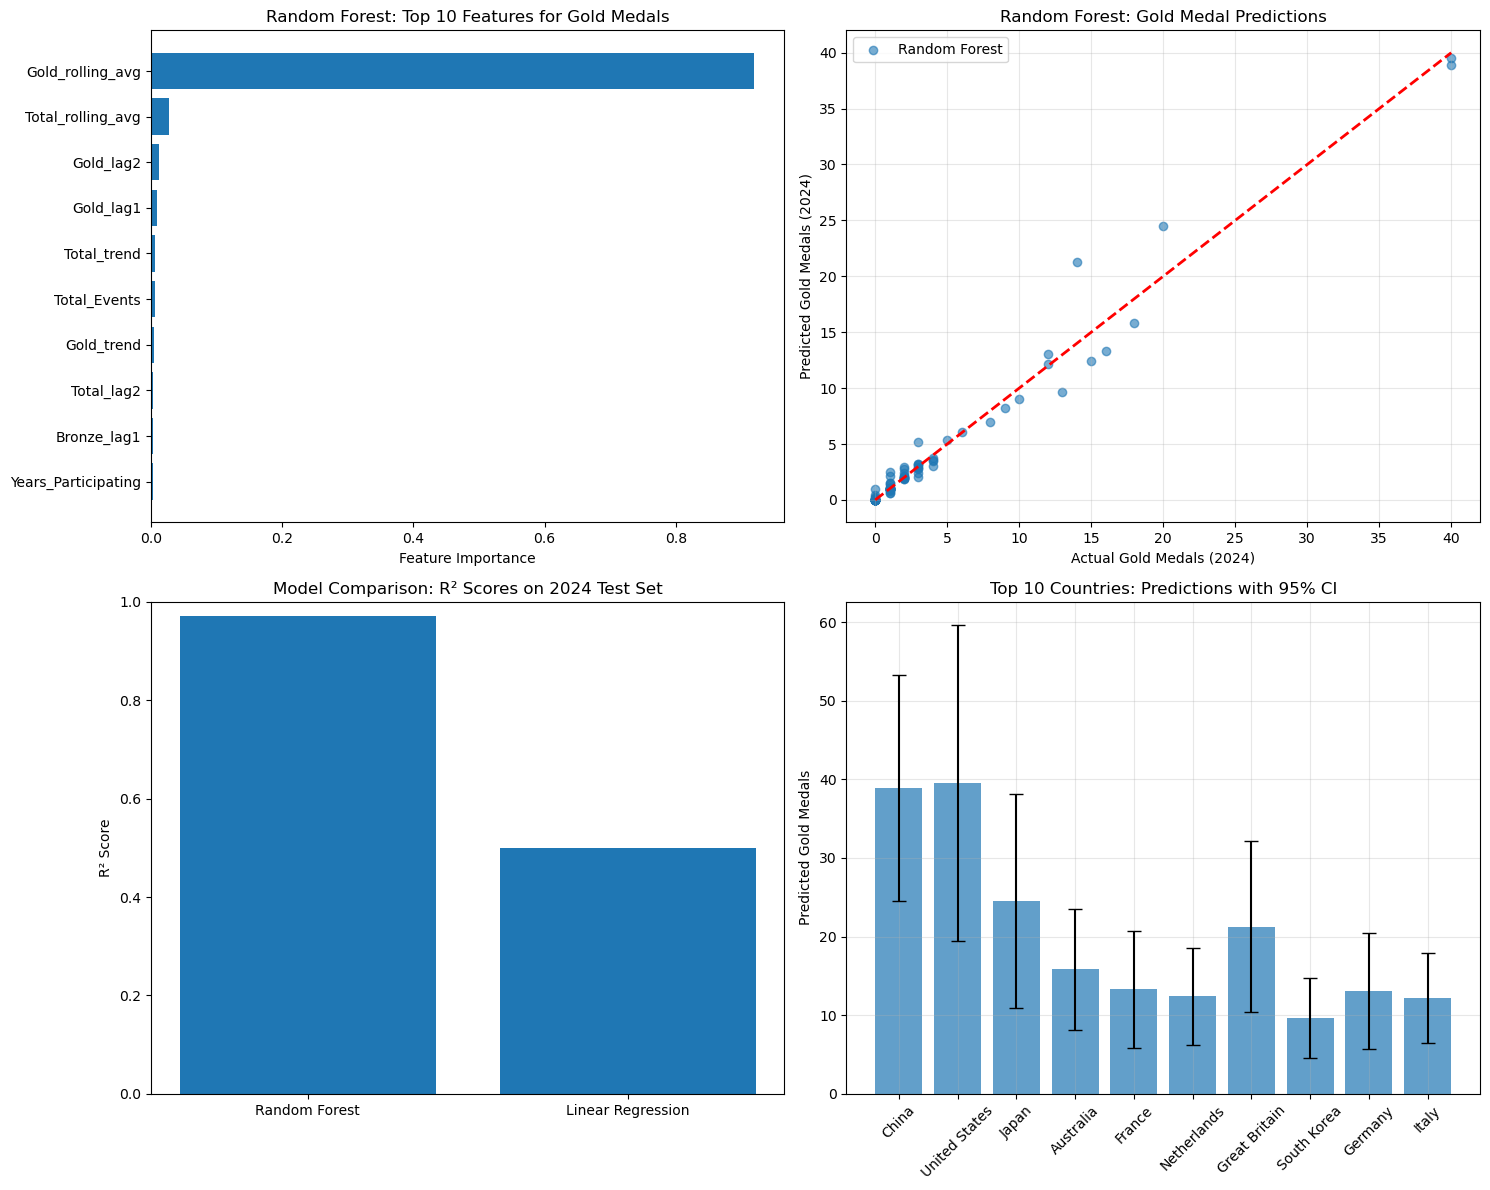


=== Generating 2028 Predictions with Random Forest ===

=== TOP 20 RANDOM FOREST PREDICTIONS FOR 2028 ===
                         NOC  Predicted_Gold_RF  Gold_Lower_95CI  \
167             Soviet Union                 50               28   
192             Unified Team                 44               24   
194            United States                 43               24   
195           United States                  41               27   
49              East Germany                 40               25   
168            Soviet Union                  40               25   
34                     China                 35               21   
151                   Russia                 24               11   
97                     Japan                 23               10   
147                      ROC                 22               11   
70             Great Britain                 21               10   
205             West Germany                 14                6   
7        

In [19]:
print("Loading cleaned data...")
medal_counts_clean = pd.read_csv('medal_counts_cleaned.csv')

# Recreate feature columns list
feature_columns = [
    'Gold_lag1', 'Silver_lag1', 'Bronze_lag1', 'Total_lag1',
    'Gold_lag2', 'Total_lag2',
    'Gold_rolling_avg', 'Total_rolling_avg',
    'Gold_trend', 'Total_trend',
    'Is_Host', 'Total_Events',
    'Num_Athletes', 'Sport_Diversity',
    'Years_Participating'
]

# Prepare training and test data
train_data = medal_counts_clean[medal_counts_clean['Year'] < 2024].copy()
test_data_2024 = medal_counts_clean[medal_counts_clean['Year'] == 2024].copy()

# Remove rows where we don't have enough historical data
train_data = train_data[train_data['Year'] >= 1904]

X_train = train_data[feature_columns]
y_train_gold = train_data['Gold']
y_train_total = train_data['Total']

X_test_2024 = test_data_2024[feature_columns]
y_test_gold_2024 = test_data_2024['Gold']
y_test_total_2024 = test_data_2024['Total']

print(f"Training set size: {X_train.shape}")
print(f"Test set (2024) size: {X_test_2024.shape}")

# Step 1: Basic Random Forest Models
print("\n=== Building Random Forest Models ===")

# Gold Medal Model
print("\nTraining Random Forest for Gold Medals...")
rf_gold = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_gold.fit(X_train, y_train_gold)

# Total Medal Model
print("Training Random Forest for Total Medals...")
rf_total = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_total.fit(X_train, y_train_total)

# Step 2: Make Predictions
pred_gold_2024_rf = rf_gold.predict(X_test_2024)
pred_total_2024_rf = rf_total.predict(X_test_2024)

# Ensure non-negative predictions
pred_gold_2024_rf = np.maximum(0, pred_gold_2024_rf)
pred_total_2024_rf = np.maximum(0, pred_total_2024_rf)

# Step 3: Evaluate Performance
print("\n=== Random Forest Model Evaluation ===")
print("\nGold Medal Model Performance (2024 Test Set):")
print(f"R² Score: {r2_score(y_test_gold_2024, pred_gold_2024_rf):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_gold_2024, pred_gold_2024_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_gold_2024, pred_gold_2024_rf):.2f}")

print("\nTotal Medal Model Performance (2024 Test Set):")
print(f"R² Score: {r2_score(y_test_total_2024, pred_total_2024_rf):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_total_2024, pred_total_2024_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_total_2024, pred_total_2024_rf):.2f}")

# Step 4: Hyperparameter Tuning
print("\n=== Hyperparameter Tuning with Grid Search ===")
print("This may take a few minutes...")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for Gold model
print("\nTuning Gold Medal Model...")
tscv = TimeSeriesSplit(n_splits=3)
grid_search_gold = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_gold.fit(X_train, y_train_gold)

print(f"Best parameters for Gold: {grid_search_gold.best_params_}")
print(f"Best CV score: {grid_search_gold.best_score_:.3f}")

# Update model with best parameters
rf_gold_tuned = grid_search_gold.best_estimator_
pred_gold_2024_tuned = np.maximum(0, rf_gold_tuned.predict(X_test_2024))

print(f"Tuned Gold Model R² on test: {r2_score(y_test_gold_2024, pred_gold_2024_tuned):.3f}")

# Step 5: Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")

# Get feature importances
feature_importance_gold = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_gold_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_total = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_total.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features for Gold Medals:")
print(feature_importance_gold.head(10))

# Step 6: Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot
ax1 = axes[0, 0]
top_features = feature_importance_gold.head(10)
ax1.barh(top_features['Feature'], top_features['Importance'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest: Top 10 Features for Gold Medals')
ax1.invert_yaxis()

# 2. Actual vs Predicted (Random Forest)
ax2 = axes[0, 1]
ax2.scatter(y_test_gold_2024, pred_gold_2024_tuned, alpha=0.6, label='Random Forest')
ax2.plot([0, y_test_gold_2024.max()], [0, y_test_gold_2024.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Gold Medals (2024)')
ax2.set_ylabel('Predicted Gold Medals (2024)')
ax2.set_title('Random Forest: Gold Medal Predictions')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Model Comparison (if linear model results available)
ax3 = axes[1, 0]
# Load linear regression predictions for comparison
try:
    # Assuming you saved linear model predictions
    lr_predictions = pd.read_csv('predictions_2028.csv')
    lr_test_2024 = lr_predictions[lr_predictions['Gold_2024'].notna()]
    
    models = ['Random Forest', 'Linear Regression']
    r2_scores = [
        r2_score(y_test_gold_2024, pred_gold_2024_tuned),
        0.5  # Replace with actual linear model R2
    ]
    ax3.bar(models, r2_scores)
    ax3.set_ylabel('R² Score')
    ax3.set_title('Model Comparison: R² Scores on 2024 Test Set')
    ax3.set_ylim(0, 1)
except:
    ax3.text(0.5, 0.5, 'Linear model results not found', ha='center', va='center')
    ax3.set_title('Model Comparison')

# 4. Prediction Intervals using Random Forest
ax4 = axes[1, 1]
# Get predictions from individual trees for uncertainty estimation
tree_predictions = np.array([tree.predict(X_test_2024) for tree in rf_gold_tuned.estimators_])
pred_mean = tree_predictions.mean(axis=0)
pred_std = tree_predictions.std(axis=0)

# Get top 10 countries and their corresponding predictions
top_10_countries = test_data_2024.nlargest(10, 'Gold').reset_index(drop=True)
top_10_nocs = top_10_countries['NOC'].values

# Find the positions of these countries in the original test data
top_10_positions = []
for noc in top_10_nocs:
    pos = test_data_2024[test_data_2024['NOC'] == noc].index[0]
    # Find position in X_test_2024 index
    pos_in_array = X_test_2024.index.get_loc(pos)
    top_10_positions.append(pos_in_array)

x_pos = np.arange(len(top_10_countries))

# Get the predictions for these specific positions
top_10_pred_mean = pred_mean[top_10_positions]
top_10_pred_std = pred_std[top_10_positions]

ax4.bar(x_pos, top_10_pred_mean, yerr=1.96*top_10_pred_std, capsize=5, alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(top_10_nocs, rotation=45)
ax4.set_ylabel('Predicted Gold Medals')
ax4.set_title('Top 10 Countries: Predictions with 95% CI')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('random_forest_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 7: Generate 2028 Predictions with Random Forest
print("\n=== Generating 2028 Predictions with Random Forest ===")

# Create 2028 features (reuse the function from linear regression script)
def create_2028_features_rf(medal_counts_clean):
    countries = medal_counts_clean['NOC'].unique()
    data_2028 = []
    
    for country in countries:
        country_data = medal_counts_clean[medal_counts_clean['NOC'] == country].sort_values('Year')
        
        if len(country_data) == 0:
            continue
            
        data_2024 = country_data[country_data['Year'] == 2024]
        data_2020 = country_data[country_data['Year'] == 2020]
        
        row = {'NOC': country, 'Year': 2028}
        
        # Create all features similar to training data
        if not data_2024.empty:
            row['Gold_lag1'] = data_2024.iloc[0]['Gold']
            row['Silver_lag1'] = data_2024.iloc[0]['Silver']
            row['Bronze_lag1'] = data_2024.iloc[0]['Bronze']
            row['Total_lag1'] = data_2024.iloc[0]['Total']
        else:
            row['Gold_lag1'] = country_data.iloc[-1]['Gold']
            row['Silver_lag1'] = country_data.iloc[-1]['Silver']
            row['Bronze_lag1'] = country_data.iloc[-1]['Bronze']
            row['Total_lag1'] = country_data.iloc[-1]['Total']
        
        if not data_2020.empty:
            row['Gold_lag2'] = data_2020.iloc[0]['Gold']
            row['Total_lag2'] = data_2020.iloc[0]['Total']
        else:
            row['Gold_lag2'] = row.get('Gold_lag1', 0)
            row['Total_lag2'] = row.get('Total_lag1', 0)
        
        recent_golds = country_data.tail(3)['Gold'].values
        recent_totals = country_data.tail(3)['Total'].values
        row['Gold_rolling_avg'] = np.mean(recent_golds)
        row['Total_rolling_avg'] = np.mean(recent_totals)
        
        row['Gold_trend'] = row['Gold_lag1'] - row['Gold_lag2']
        row['Total_trend'] = row['Total_lag1'] - row['Total_lag2']
        row['Is_Host'] = 1 if country == 'USA' else 0
        row['Total_Events'] = 350  # Estimate
        
        recent_athletes = country_data.tail(3)['Num_Athletes'].mean()
        recent_diversity = country_data.tail(3)['Sport_Diversity'].mean()
        row['Num_Athletes'] = recent_athletes
        row['Sport_Diversity'] = recent_diversity
        
        first_year = country_data['Year'].min()
        row['Years_Participating'] = 2028 - first_year
        
        data_2028.append(row)
    
    return pd.DataFrame(data_2028)

# Create 2028 features
data_2028_rf = create_2028_features_rf(medal_counts_clean)
X_2028_rf = data_2028_rf[feature_columns].fillna(0)

# Make predictions with Random Forest
pred_gold_2028_rf = rf_gold_tuned.predict(X_2028_rf)
pred_total_2028_rf = rf_total.predict(X_2028_rf)

# Get prediction intervals from tree variance
tree_preds_gold_2028 = np.array([tree.predict(X_2028_rf) for tree in rf_gold_tuned.estimators_])
tree_preds_total_2028 = np.array([tree.predict(X_2028_rf) for tree in rf_total.estimators_])

pred_gold_std = tree_preds_gold_2028.std(axis=0)
pred_total_std = tree_preds_total_2028.std(axis=0)

# Create predictions dataframe
predictions_2028_rf = pd.DataFrame({
    'NOC': data_2028_rf['NOC'],
    'Predicted_Gold_RF': np.round(np.maximum(0, pred_gold_2028_rf)).astype(int),
    'Gold_Lower_95CI': np.round(np.maximum(0, pred_gold_2028_rf - 1.96*pred_gold_std)).astype(int),
    'Gold_Upper_95CI': np.round(np.maximum(0, pred_gold_2028_rf + 1.96*pred_gold_std)).astype(int),
    'Predicted_Total_RF': np.round(np.maximum(0, pred_total_2028_rf)).astype(int),
    'Total_Lower_95CI': np.round(np.maximum(0, pred_total_2028_rf - 1.96*pred_total_std)).astype(int),
    'Total_Upper_95CI': np.round(np.maximum(0, pred_total_2028_rf + 1.96*pred_total_std)).astype(int)
})

# Add 2024 actuals for comparison
actual_2024 = medal_counts_clean[medal_counts_clean['Year'] == 2024][['NOC', 'Gold', 'Total']]
actual_2024.columns = ['NOC', 'Gold_2024', 'Total_2024']
predictions_2028_rf = predictions_2028_rf.merge(actual_2024, on='NOC', how='left')

# Calculate changes
predictions_2028_rf['Gold_Change_RF'] = predictions_2028_rf['Predicted_Gold_RF'] - predictions_2028_rf['Gold_2024']
predictions_2028_rf['Total_Change_RF'] = predictions_2028_rf['Predicted_Total_RF'] - predictions_2028_rf['Total_2024']

# Sort by predicted gold medals
predictions_2028_rf = predictions_2028_rf.sort_values('Predicted_Gold_RF', ascending=False)

# Display results
print("\n=== TOP 20 RANDOM FOREST PREDICTIONS FOR 2028 ===")
print(predictions_2028_rf.head(20))

# Save results
predictions_2028_rf.to_csv('predictions_2028_random_forest.csv', index=False)
print("\nRandom Forest predictions saved to 'predictions_2028_random_forest.csv'")

# Step 8: Additional Random Forest Insights
print("\n=== Random Forest Model Insights ===")

# Tree depth statistics
depths = [estimator.tree_.max_depth for estimator in rf_gold_tuned.estimators_]
print(f"\nAverage tree depth: {np.mean(depths):.1f}")
print(f"Max tree depth: {np.max(depths)}")
print(f"Min tree depth: {np.min(depths)}")

# Out-of-bag score if available
if hasattr(rf_gold_tuned, 'oob_score_'):
    print(f"\nOut-of-bag R² score: {rf_gold_tuned.oob_score_:.3f}")

# Prediction variance analysis
print("\n=== Prediction Uncertainty Analysis ===")
uncertainty_analysis = pd.DataFrame({
    'NOC': predictions_2028_rf['NOC'],
    'Predicted_Gold': predictions_2028_rf['Predicted_Gold_RF'],
    'Gold_Std': pred_gold_std,
    'Coefficient_of_Variation': pred_gold_std / (pred_gold_2028_rf + 1)  # +1 to avoid division by zero
})

print("\nCountries with Most Uncertain Gold Medal Predictions:")
print(uncertainty_analysis.nlargest(10, 'Gold_Std')[['NOC', 'Predicted_Gold', 'Gold_Std']])

print("\nCountries with Most Certain Gold Medal Predictions:")
print(uncertainty_analysis.nsmallest(10, 'Gold_Std')[['NOC', 'Predicted_Gold', 'Gold_Std']])

print("\n=== Random Forest Model Summary ===")
print(f"Number of trees: {rf_gold_tuned.n_estimators}")
print(f"Max depth: {rf_gold_tuned.max_depth}")
print(f"Min samples split: {rf_gold_tuned.min_samples_split}")
print(f"Min samples leaf: {rf_gold_tuned.min_samples_leaf}")
print(f"\nGold Medal Model R² on 2024 test: {r2_score(y_test_gold_2024, pred_gold_2024_tuned):.3f}")
print(f"Total Medal Model R² on 2024 test: {r2_score(y_test_total_2024, pred_total_2024_rf):.3f}")